El objetivo es clasificar a las personas de acuerdo con su capacidad financiera. Sin embargo, no hay alguna etiqueta de "capacidad financiera" en el conjunto de datos, sino que esta es una variable latente multidimensional, por lo que será necesario considerar inicialmente todas las variables y seleccionar aquellas que aporten información relevante al concepto basado en cierto criterio. Posteriormente, se propondrá la costrucción de un índice basado en el uso de componentes principales. Y se finalizará con la discretización de este índice para la clasificación.

In [ ]:
import pandas as pd
thogar = pd.read_csv("/content/conjunto_de_datos_thogar_enif2024.csv")
tmodulo = pd.read_csv("/content/conjunto_de_datos_tmodulo_enif2024.csv")
tsdem = pd.read_csv("/content/conjunto_de_datos_tsdem_enif2024.csv")
tvivienda = pd.read_csv("/content/conjunto_de_datos_tvivienda_enif2024.csv")

- El conjunto de datos `thogar` contiene datos a nivel hogar, pero el análisis es sobre la capacidad financiera de las personas, no del hogar, por lo que no nos interesa.

- Similarmente, los datos sociodemográficos de `tsdem` no nos interesan para formar una clasificación. Quizá después podrían servir como predictores de la capacidad financiera, o para hacer conglomerados, pero por ahora no parece conveniente usarlos para la clasificación.

- Los datos de la `tvivienda`, aunque no no son el núcleo de la capacidad financiera, sí podrían proporcionar información sobre ella, en tanto que complementan el diagnóstico sobre el contexto económico del hogar.

- `tmodulo` contiene gran cantidad de variables directamente relacionadas con la capacidad financiera de las personas, por lo que será el centro de nuestro análisis.

Observando el diagrama ER, `tvivienda` tiene una relación uno a muchos con `tmodulo`, por lo que haremos una LEFT JOIN para obtener una nueva base de datos con todas las variables de interés.

In [ ]:
df = tmodulo.merge(tvivienda, on='llaveviv', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13502 entries, 0 to 13501
Columns: 416 entries, llavemod to fac_viv
dtypes: float64(262), int64(154)
memory usage: 42.9 MB


Se tienen un total de 416 variables. Lo siguiente es hacer una selección de variables de acuerdo con la definición de *capacidad financiera*. Para ello, creamos una lista con palabras clave en la definición de capacidad financiera, y extraemos aquellos nombres de variables cuya descripción contenga coincidencias semánticas con la definición en cuestión. Esto nos permite reducir la dimensionalidad del conjunto de datos, conservando variables relevantes para la variable latente objetivo.

Posteriormente, se crea un nuevo data frame filtrando aquellas variables seleccionadas, agregando también una lista de variables escogidas relativas a la vivienda, pues el análisis semántico para la selección de variables solo se hace con las variables relativas al módulo.

In [ ]:
import pandas as pd

# Eliminamos las claves, que no aprtan información útil a partir de ahora.
df = df.drop(["llaveviv", "llavehog"], axis=1)

# Diccionario que contiene los nombres de los campos y sus descripciones.
dic_modulo = pd.read_csv("diccionario_datos_tmodulo_enif2024.csv")

# Lista de palabras clave basadas en la definición de capacidad financiera.
criterios_cp = [
    "conocimiento", "sabe", "saber", "conoce", "conocer", "entender",
    "actitud", "comportamiento", "hábito", "hábitos", "acción",
    "gasta", "gasto", "ahorra", "ahorro", "ingreso", "ingresos",
    "endeuda", "endeudamiento", "crédito", "cuenta", "banco", "gana",
    "seguro", "financiera", "finanzas", "manejo", "decisión", "decisiones",
    "uso de", "confianza", "retiro", "retiros", "pago", "pagos",
    "presupuesto", "dinero", "riesgo", "cobertura", "interés", "contratar", "ahorrado",
    "económico", "economico", "financiero", "financieros", "producto financiero",
    "tarjeta de crédito", "tarjeta de débito", "tarjeta bancaria"
]

# Identificar variables relevantes según si contienen alguna palabra clave en su descripción.
dic_modulo['relevante'] = dic_modulo['nombre_campo'].str.lower().apply(
    lambda texto: any(p in texto for p in criterios_cp)
)

# Extraer nombre de las variables relevantes.
variables_relevantes = dic_modulo[dic_modulo['relevante']][['nombre_campo', 'catálogo']]
var_rel_nom = dic_modulo.loc[dic_modulo['relevante'], 'catálogo'].dropna().astype(str).str.strip().tolist()
var_rel_nom += ["llavemod", "p0_2", "p0_3", "p0_4_1", "p0_4_1a", "p0_4_2", "p1_1"]

# Filtrar solo las variables que existen en df.
var_rel_nom = [v for v in var_rel_nom if v in df.columns]
df2 = df[var_rel_nom].copy()
print(df2.info())

# Ver tabla de variables relevantes.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# print(variables_relevantes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13502 entries, 0 to 13501
Columns: 309 entries, p3_4 to p1_1
dtypes: float64(220), int64(89)
memory usage: 31.8 MB
None


Analizando las variables con mayor cantidad de datos faltantes, se seleccionó un umbral del 20 % de datos faltantes como condición suficiente para eliminar las variables. La razón por la cual se escogió este umbral tan bajo es porque en su gran mayoría los datos faltantes pertenecen a variables condicionales, es decir, son preguntas que se hacen si su respuesta a cierta pregunta fue "Sí" (por ejemplo), sin embargo, la pregunta inicial contiene la información más relevante de ese bloque de preguntas, mientras que el resto son precisiones.

Además, se revisaron aquellas variables con porcentaje de datos faltantes menores al umbral, y seguían el mismo patrón: la pregunta inicial del bloque contenía la información relevante, por lo que también fueron eliminadas manualmente.

In [ ]:
import pandas as pd

# Calcular número y porcentaje de valores faltantes por columna.
resumen = pd.DataFrame({
    'faltantes': df2.isnull().sum(),
    'porcentaje': (df2.isnull().mean() * 100).round(2)
}).T

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(resumen)

            p3_4  p3_5_7   p3_11a    p3_12  p4_1  p4_2_1  p4_2_2  p4_2_4  p4_2_5  p4_3   p4_4_1   p4_4_2   p4_4_3   p4_4_4   p4_4_5   p4_4_6   p4_4_7  p4_5  p4_6_2  p4_6_3  p4_6_4  p4_6_5  p4_6_6  p4_7_2  p4_7_3  p4_8_2  p4_8_3  p4_8_5  p4_8_6  p4_9_1  p4_9_2  p4_10  p4_12_02  p4_12_04  p4_12_05  p4_12_06  p4_12_99  p5_1_1  p5_1_3  p5_1_4  p5_1_6   p5_2_1   p5_2_2   p5_2_3   p5_2_4   p5_2_5   p5_2_6   p5_2_7   p5_2_8   p5_2_9     p5_3  p5_4_1   p5_5_1   p5_6_1  p5_4_2    p5_5_2    p5_6_2  p5_4_3    p5_5_3    p5_6_3  p5_4_4    p5_5_4    p5_6_4  p5_4_5    p5_5_5    p5_6_5  p5_4_8    p5_5_8    p5_6_8  p5_4_9    p5_5_9    p5_6_9  p5_7_01  p5_7_02  p5_7_03  p5_7_04  p5_7_05  p5_7_06  p5_7_07  p5_7_08  p5_7_09  p5_7_10  p5_7_99  filtro_s5_1  p5_8_1  p5_8_2  p5_8_3  p5_8_4  p5_8_5  p5_8_6  p5_8_7  p5_8_8  p5_8_9    p5_9  filtro_s5_2    p5_10  filtro_s5_3    p5_11     p5_12    p5_14   p5_15_1   p5_15_2   p5_15_3   p5_15_4   p5_15_5   p5_15_6   p5_15_7    p5_16  p5_17_1  p5_17_2  p5_17_3  \
fal

In [ ]:
umbral = 0.20
# Identificar columnas con más de 'umbral' de valores faltantes.
columnas_por_umbral = df2.columns[df2.isnull().mean() > umbral].tolist()

# Otras columnas con valores faltantes a eliminar por "selección conceptual".
columnas_manual = ["p9_9_1", "p9_9_2", "p9_9_3", "p9_9_4", "p9_9_5", "p9_9_6", "p7_9_2_2", "p7_9_1_2"]

columnas_a_eliminar = list(set(columnas_por_umbral + columnas_manual))
df3 = df2.drop(columns=columnas_a_eliminar)

print(f"Columnas eliminadas: {len(columnas_a_eliminar)}")
print(f"Columnas restantes: {df3.shape[1]}")
print("Columnas eliminadas:", columnas_a_eliminar)

Columnas eliminadas: 220
Columnas restantes: 89
Columnas eliminadas: ['p3_12', 'p6_11_5', 'p5_2_4', 'p6_17_2', 'p6_4_8', 'p9_6_8', 'p6_4_1', 'p6_17_9', 'filtro_s5_3', 'p5_7_08', 'p5_6_8', 'p6_17_1', 'p6_5_1', 'p4_12_99', 'p8_8_4', 'p5_15_6', 'p5_6_5', 'p8_6_4', 'p4_4_5', 'p8_12_4', 'p9_6_2', 'p6_17_6', 'p8_12_1', 'p8_6_2', 'p8_10_5', 'p6_4_7', 'p5_15_3', 'p5_17_5', 'p6_11_6', 'p8_5_5', 'p8_7_8', 'p5_7_06', 'p6_17_4', 'p5_24_4', 'p8_6_8', 'p8_10_1', 'p5_17_2', 'p8_6_5', 'filtro_s8_1', 'p4_4_6', 'p8_10_2', 'p5_9', 'p11_6_4', 'p0_4_1a', 'p6_9', 'p4_4_3', 'p8_3', 'p5_2_8', 'p5_3', 'p9_6_1', 'p4_4_4', 'p5_6_3', 'filtro_s5_2', 'p6_11_7', 'p7_9_4_2', 'p8_12_7', 'p6_12a', 'p5_2_1', 'p5_5_4', 'p5_21', 'p6_3_1', 'p9_3', 'p5_5_8', 'p9_9_4', 'p5_19', 'p5_2_7', 'p6_12', 'p11_7', 'p6_3_6', 'p5_8_4', 'p8_12_3', 'p8_8_8', 'p5_7_02', 'p6_15', 'p5_8_7', 'p4_12_02', 'p5_8_3', 'p5_8_9', 'p4_4_2', 'p9_8', 'p9_6_4', 'p4_12_05', 'p5_18', 'p6_10', 'p5_15_1', 'p7_9_5_2', 'p8_12_5', 'p5_7_07', 'p8_7_4', 'p9_9_1

In [ ]:
df3.isnull().sum().sum()

np.int64(0)

La eliminación justificada de variables permitió obtener un conjunto de datos casi sin valores faltantes. Dado que los porcentajes de datos faltantes son muy bajos por variable (0.03 %), es intuitivo pensar que quizá se trate de algunas observaciones problemáticas, evidenciado a continuación.

In [ ]:
df3[df3.isnull().any(axis=1)]

,p3_4,p3_5_7,p4_1,p4_2_1,p4_2_2,p4_2_4,p4_2_5,p4_3,p4_5,p4_6_2,p4_6_3,p4_6_4,p4_6_5,p4_6_6,p4_7_2,p4_7_3,p4_8_2,p4_8_3,p4_8_5,p4_8_6,p4_9_1,p4_9_2,p4_10,p5_1_1,p5_1_3,p5_1_4,p5_1_6,p5_4_1,p5_4_2,p5_4_3,p5_4_4,p5_4_5,p5_4_8,p5_4_9,p5_23,p6_1_1,p6_2_1,p6_2_2,p6_2_3,p6_2_4,p6_2_5,p6_2_6,p6_2_7,p6_2_8,p6_2_9,p6_16,p7_1_1,p7_1_2,p7_2_1,p7_2_2,p7_5,p7_7,p7_8_3,p7_8_4,p7_10,p8_1,p9_1,p10_1,p10_4,p10_7,p11_1_1,p11_1_2,p11_1_3,p11_1_4,p11_1_5,p11_2_1,p11_2_2,p11_2_3,p11_3_1,p11_3_2,p11_3_3,p11_3_4,p11_3_5,p11_3_6,p11_3_9,p11_6_1,p11_6_2,p11_6_3,p12_1,p12_2,p12_3,p12_4,p13_1,llavemod,p0_2,p0_3,p0_4_1,p0_4_2,p1_1


La `llavemod` 305803101 es la problemática, por lo tanto, basta con eliminar esta fila para tener un conjunto de datos sin datos faltantes.

In [ ]:
df3 = df3[df3['llavemod'] != 305803101]
df3.isnull().sum().sum()

np.int64(0)

A continuación se muestra el número de valores diferentes que toma cada una de las variables. Analizándolas, solo las últimas tres variables relativas a la vivienda son realmente numéricas (sin contar `llavemod`); el resto, aunque en esencia deberían ser ordinales, la construcción de las mismas impide manejarlas como tal (por ejemplo, tienen 5 opciones de respuesta, donde dos o tres tienen orden, pero el resto no).

In [ ]:
nunique_series = df3.nunique().sort_values()
print(nunique_series.T.to_frame().T)

   p3_4  p4_1  p4_2_1  p4_2_2  p4_2_5  p4_2_4  p4_3  p4_5  p5_1_3  p5_1_4  p5_1_6  p5_4_1  p5_4_2  p4_9_1  p5_1_1  p4_9_2  p5_4_4  p5_4_3  p5_4_5  p6_2_9  p6_2_8  p6_2_7  p6_2_6  p6_2_5  p6_2_4  p6_2_3  p6_2_2  p6_2_1  p6_1_1  p5_23  p5_4_9  p5_4_8  p10_7  p7_8_4  p10_4  p7_7  p7_8_3  p10_1  p7_2_2  p7_2_1  p7_5  p11_3_6  p11_3_9  p11_6_3  p11_3_1  p11_3_2  p11_3_3  p11_3_4  p11_3_5  p0_4_2  p0_4_1  p11_1_2  p11_2_1  p11_1_5  p11_6_2  p11_6_1  p11_1_4  p7_1_2  p11_1_1  p9_1  p11_1_3  p8_1  p6_16  p7_1_1  p13_1  p12_1  p11_2_2  p11_2_3  p4_7_3  p3_5_7  p12_4  p4_7_2  p4_6_5  p4_6_4  p4_8_6  p4_6_6  p4_8_5  p4_8_3  p4_6_2  p4_8_2  p12_3  p12_2  p4_6_3  p7_10  p4_10  p0_3  p0_2  p1_1  llavemod
0     2     2       2       2       2       2     2     2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2       2      2       2       2      2       2      2     2       2      2       2 

In [47]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13501 entries, 0 to 13501
Data columns (total 89 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   p3_4      13501 non-null  int64
 1   p3_5_7    13501 non-null  int64
 2   p4_1      13501 non-null  int64
 3   p4_2_1    13501 non-null  int64
 4   p4_2_2    13501 non-null  int64
 5   p4_2_4    13501 non-null  int64
 6   p4_2_5    13501 non-null  int64
 7   p4_3      13501 non-null  int64
 8   p4_5      13501 non-null  int64
 9   p4_6_2    13501 non-null  int64
 10  p4_6_3    13501 non-null  int64
 11  p4_6_4    13501 non-null  int64
 12  p4_6_5    13501 non-null  int64
 13  p4_6_6    13501 non-null  int64
 14  p4_7_2    13501 non-null  int64
 15  p4_7_3    13501 non-null  int64
 16  p4_8_2    13501 non-null  int64
 17  p4_8_3    13501 non-null  int64
 18  p4_8_5    13501 non-null  int64
 19  p4_8_6    13501 non-null  int64
 20  p4_9_1    13501 non-null  int64
 21  p4_9_2    13501 non-null  int64
 22  p4_

Ahora se separarán las variables numéricas y nominales. Las nominales serán transformadas mediante codificación one-hot, lo cual permitirá convertir las categorías en variables binarias. Las variables numéricas se mantendrán tal cual. Posteriormente, todas las variables serán escaladas con StandardScaler para que tengan media cero y desviación estándar uno. Esto es crucial porque el PCA es sensible a la escala de las variables.

In [ ]:
import pandas as pd

# Cargar diccionario de variables.
dic_modulo = pd.read_csv("diccionario_datos_tmodulo_enif2024.csv")

# Filtrar diccionario solo con variables que están en df3.
variables_df3 = dic_modulo[dic_modulo['catálogo'].isin(df3.columns)]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)  # o usa float('inf') si prefieres
tabla_descripcion = variables_df3[['catálogo', 'nombre_campo']]
print(tabla_descripcion)

    catálogo                                                                                                                                                                                                                                                                                               nombre_campo
9       p3_4                                                                                                                                     Pregunta P3.4 ¿Usted recibe algún apoyo económico o programa de gobierno (personas adultas mayores, becas Benito Juárez, Jóvenes construyendo el futuro, entre otros)?
16    p3_5_7   Pregunta P3.5.7 Ahora le entregaré esta tarjeta para que me responda las siguientes preguntas (ENTREGUE LA TARJETA 1). Identifique su respuesta con un número del 1 al 4. En su vida diaria, ¿usted cuánta dificultad tiene para hablar o comunicarse (por ejemplo, entender o ser entendido por otros)?
32      p4_1                                                    

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Variables ordinales.
numericas = ['p0_2', 'p0_3', 'p1_1']
categoricas = [col for col in df3.columns if col not in numericas + ['llavemod']]

# One-hot encoding de las categóricas nominales.
df_cat = pd.get_dummies(df3[categoricas], drop_first=True)

# Concatenación de ordinales + categóricas codificadas.
df_procesado = pd.concat([df3[numericas].reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

# Escalado.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_procesado)

print(f"Forma final del conjunto procesado: {X_scaled.shape}")

Forma final del conjunto procesado: (13501, 88)


Se aplicará el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad del conjunto y resumir la información financiera en pocos ejes. Se usarán los primeros cinco componentes, y se construirá un índice ponderado combinando las componentes según su proporción de varianza explicada. Este índice servirá como representación unidimensional de la capacidad financiera.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# PCA con 5 componentes principales.
n_componentes = 40
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(X_scaled)

# Obtener proporciones de varianza explicada.
varianzas = pca.explained_variance_ratio_

# Índice financiero: combinación lineal ponderada.
indice_financiero = np.dot(X_pca, varianzas)

# Armar tabla.
tabla_indices = df3[['llavemod']].copy()
tabla_indices['Indice_financiero'] = indice_financiero

print(tabla_indices.head())

   llavemod  Indice_financiero
0    101101          -0.662753
1    210101          -0.686279
2    303102          -0.338333
3    401101          -0.292944
4    503101           0.246904


En este paso se explorarán los resultados del PCA con mayor detalle. Se examinará qué porcentaje de varianza explica cada componente, cuál es la varianza acumulada y qué pesos (cargas) tienen las variables en los componentes. Además, se calculará el índice de silueta para evaluar si los datos proyectados por PCA permiten distinguir grupos con claridad mediante clustering.


--- Varianza explicada ---
    Componente  Varianza %  Varianza acumulada %
0            1       11.75                 11.75
1            2        3.66                 15.41
2            3        3.00                 18.41
3            4        2.60                 21.01
4            5        2.33                 23.35
5            6        2.06                 25.41
6            7        1.97                 27.38
7            8        1.83                 29.21
8            9        1.80                 31.01
9           10        1.69                 32.70
10          11        1.63                 34.33
11          12        1.52                 35.85
12          13        1.44                 37.29
13          14        1.41                 38.70
14          15        1.37                 40.07
15          16        1.31                 41.38
16          17        1.24                 42.61
17          18        1.22                 43.83
18          19        1.20               

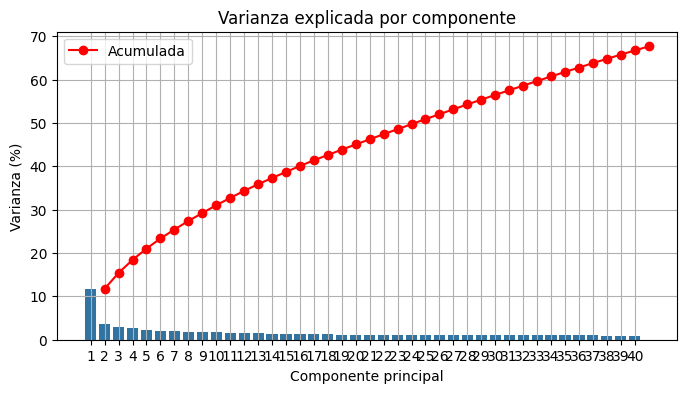


Silhouette Score (con KMeans sobre PCA): 0.091


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Varianza explicada por componente.
var_exp = pca.explained_variance_ratio_
acum_exp = np.cumsum(var_exp)

# Tabla de varianza.
tabla_varianza = pd.DataFrame({
    'Componente': np.arange(1, n_componentes + 1),
    'Varianza %': (var_exp * 100).round(2),
    'Varianza acumulada %': (acum_exp * 100).round(2)
})
print("\n--- Varianza explicada ---")
print(tabla_varianza)

# Gráfico de varianza explicada.
plt.figure(figsize=(8, 4))
sns.barplot(x=tabla_varianza['Componente'], y=tabla_varianza['Varianza %'])
plt.plot(tabla_varianza['Componente'], tabla_varianza['Varianza acumulada %'], color='red', marker='o', label='Acumulada')
plt.title("Varianza explicada por componente")
plt.xlabel("Componente principal")
plt.ylabel("Varianza (%)")
plt.legend()
plt.grid(True)
plt.show()

# Cargas (pesos de variables).
cargas = pd.DataFrame(
    pca.components_.T,
    index=df_procesado.columns,
    columns=[f'PC{i+1}' for i in range(n_componentes)]
)
#print("\n--- Cargas de variables ---")
#print(cargas.round(3))

# Silhouette Score sobre datos proyectados.
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)
silueta = silhouette_score(X_pca, labels)
print(f"\nSilhouette Score (con KMeans sobre PCA): {silueta:.3f}")

A partir del índice continuo de capacidad financiera, se generará una clasificación ordinal en tres niveles (grados). Se usarán terciles (qcut) para garantizar una distribución balanceada entre las clases. Esta clasificación permitirá análisis comparativos posteriores entre grupos de baja, media y alta capacidad.

In [50]:
# Clasificar en 3 grados ordinales.
tabla_indices['Grado_financiero'] = pd.qcut(
    tabla_indices['Indice_financiero'],
    q=3,
    labels=[1, 2, 3]
).astype(int)

print(tabla_indices.head(20))

    llavemod  Indice_financiero  Grado_financiero
0     101101          -0.662753                 1
1     210101          -0.686279                 1
2     303102          -0.338333                 1
3     401101          -0.292944                 1
4     503101           0.246904                 3
5     603102           0.342867                 3
6     704101           0.173962                 3
7     803102          -0.151144                 2
8     904102          -0.031295                 2
9    1004101           0.242732                 3
10   1102102           0.666169                 3
11   1201102          -0.144713                 2
12   1303104          -0.313014                 1
13   1408102           0.528913                 3
14   1504101           0.065670                 2
15   1609104          -0.120863                 2
16   1704101           0.003241                 2
17   1816102           0.485603                 3
18   1904105          -0.180112                 1


**Interpretación del índice construído**
El **índice de capacidad financiera** es una variable continua construida mediante un Análisis de Componentes Principales (PCA), que resume la información proveniente de un conjunto de variables numéricas y categóricas nominales relacionadas con el comportamiento, acceso y el conocimiento financiera. Por ahora, la finalidad fue discretizar este índice para formar tres categorías que permitan clasificar a las personas de acuerdo con su capacidad financiera.

Este índice representa, en una sola dimensión, el nivel estimado de capacidad financiera de cada persona. No es posible concluir, por ahora, que valores más altos del índice, se interpretan en que la persona tiene mejor comportamiento, más aceso y conocimiento financiero (por ejemplo, uso de cuentas bancarias, ahorro regular, uso de seguros, conocimiento financiero básico, etc.). Para ello, debería revisarse detalladamente qué representa cada variable dummy creada con OneHot Encoder, porque el índice formado es una suma ponderada de los valores de estas variables dummy, es decir, solo indica presencia o ausencia de una determinada característica.


Finalmente, a continuación se muestran promedios o proporciones por grados y por variables. Se usará una tabla descriptiva para comparar el comportamiento promedio de variables numéricas relevantes según el grado asignado. Esto permitirá verificar si los grupos realmente discriminan entre distintos niveles de capacidad financiera.

In [ ]:
# Estadísticas descriptivas por grado (una fila por grado).
descriptivas = df_validacion.groupby('Grado_financiero')[variables_usadas].mean().round(2)

# Mostrar en horizontal.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\nEstadísticas descriptivas por grado de capacidad financiera (horizontal):")
print(descriptivas)


Estadísticas descriptivas por grado de capacidad financiera (horizontal):
                  p0_2  p0_3  p1_1  p3_4  p3_5_7  p4_1  p4_2_1  p4_2_2  p4_2_4  p4_2_5  p4_3  p4_5  p4_6_2  p4_6_3  p4_6_4  p4_6_5  p4_6_6  p4_7_2  p4_7_3  p4_8_2  p4_8_3  p4_8_5  p4_8_6  p4_9_1  p4_9_2  p4_10  p5_1_1  p5_1_3  p5_1_4  p5_1_6  p5_4_1  p5_4_2  p5_4_3  p5_4_4  p5_4_5  p5_4_8  p5_4_9  p5_23  p6_1_1  p6_2_1  p6_2_2  p6_2_3  p6_2_4  p6_2_5  p6_2_6  p6_2_7  p6_2_8  p6_2_9  p6_16  p7_1_1  p7_1_2  p7_2_1  p7_2_2  p7_5  p7_7  p7_8_3  p7_8_4  p7_10  p8_1  p9_1  p10_1  p10_4  p10_7  p11_1_1  p11_1_2  p11_1_3  p11_1_4  p11_1_5  p11_2_1  p11_2_2  p11_2_3  p11_3_1  p11_3_2  p11_3_3  p11_3_4  p11_3_5  p11_3_6  p11_3_9  p11_6_1  p11_6_2  p11_6_3  p12_1  p12_2  p12_3  p12_4  p13_1  p0_4_1  p0_4_2
Grado_financiero                                                                                                                                                                                                            

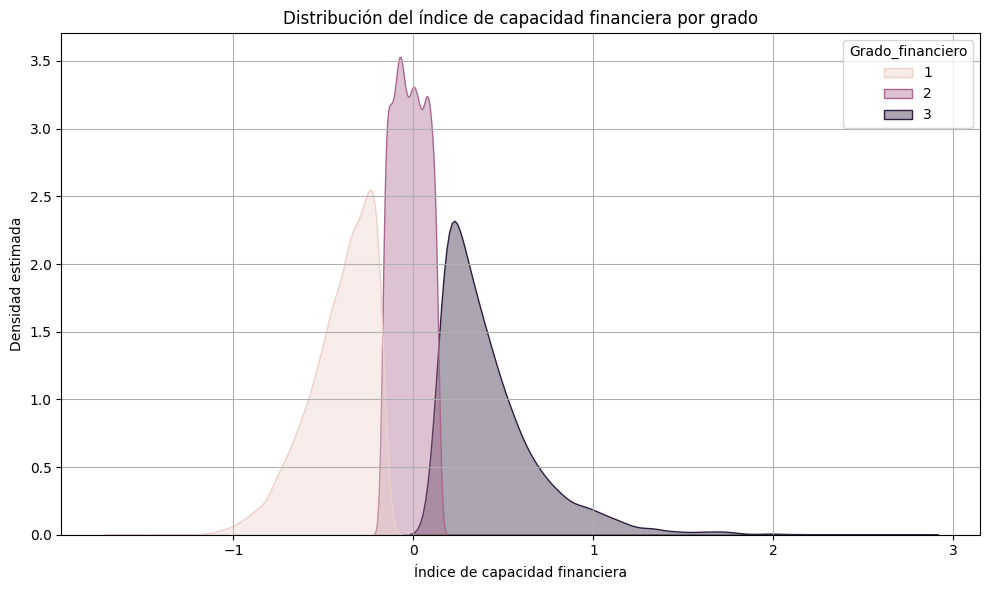

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfica de densidad.
plt.figure(figsize=(10, 6))
sns.kdeplot(data=tabla_indices, x='Indice_financiero', hue='Grado_financiero', fill=True, common_norm=False, alpha=0.4)

plt.title('Distribución del índice de capacidad financiera por grado')
plt.xlabel('Índice de capacidad financiera')
plt.ylabel('Densidad estimada')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Exportar tabla con identificador, índice y grado
tabla_indices.to_csv("clasificacion_capacidad_financiera.csv", index=False)

print("Archivo exportado como 'clasificacion_capacidad_financiera.csv'")

Archivo exportado como 'clasificacion_capacidad_financiera.csv'


**¿Qué sigue y cómo mejorar?**
1. Se sugiere revisar intepretaciones de los componentes principales y/o explorar también con un análisis factorial.
2. Analizar las variables dummies creadas para buscar interpretación en el índice formado y en su discretización.
3. Explorar clasificaciones usando clustering (por ejemplo, K-Means), y comparar los resultados con el índice creado y su discretización.
4. Hacer un análisis már riguroso en la selección de variables. Mejorar las búsquedas semánticas en relación a la definición de capacidad financiera. Analizar detalladamente cada una de las variables seleccionadas y hacer un nuevo filtro de aquellas que tengan un valor conceptual elevado relativo a la capacidad financiera.
5. Explorar otras formas de clasificación y comparlas con las anteriores. Si hay consistencia, significa que probablemente se está identificando correctamente la capacidad financiera y creando una clasificación racional a partir de ella.
6. Otra forma de abordar el problema consistía en leer directamente las descripciones de las variables e ir seleccionando manualmente y ordinalizar estas variables seleccionadas. Sin embargo, esto requiere mucho más tiempo.